In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

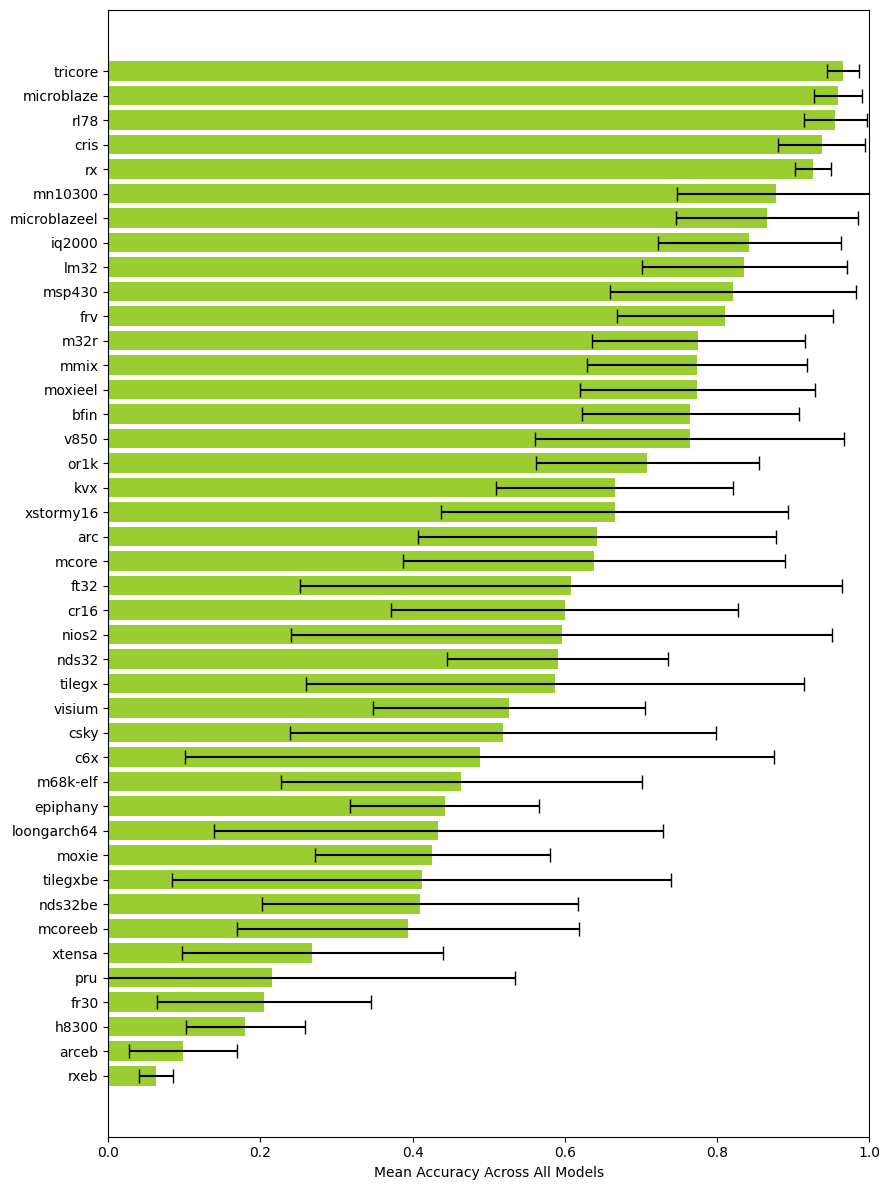

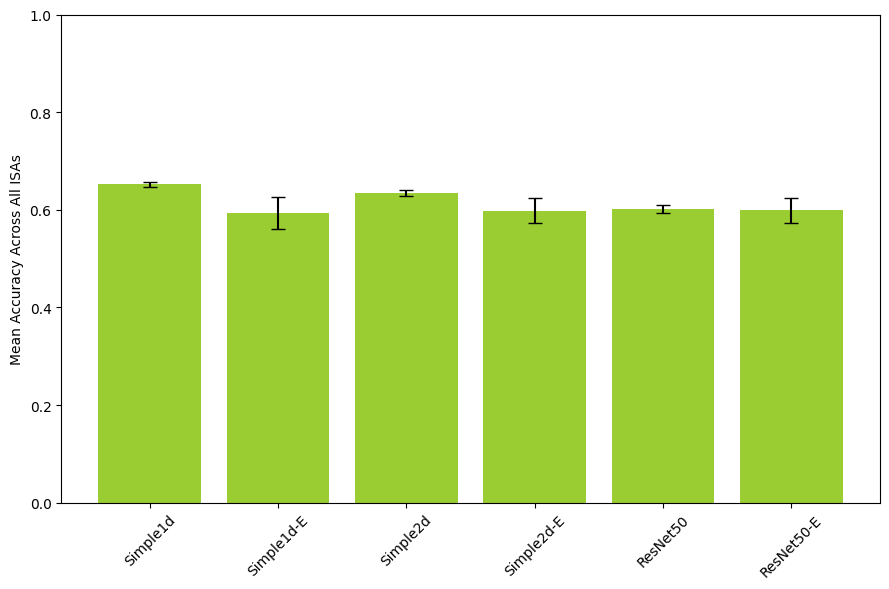

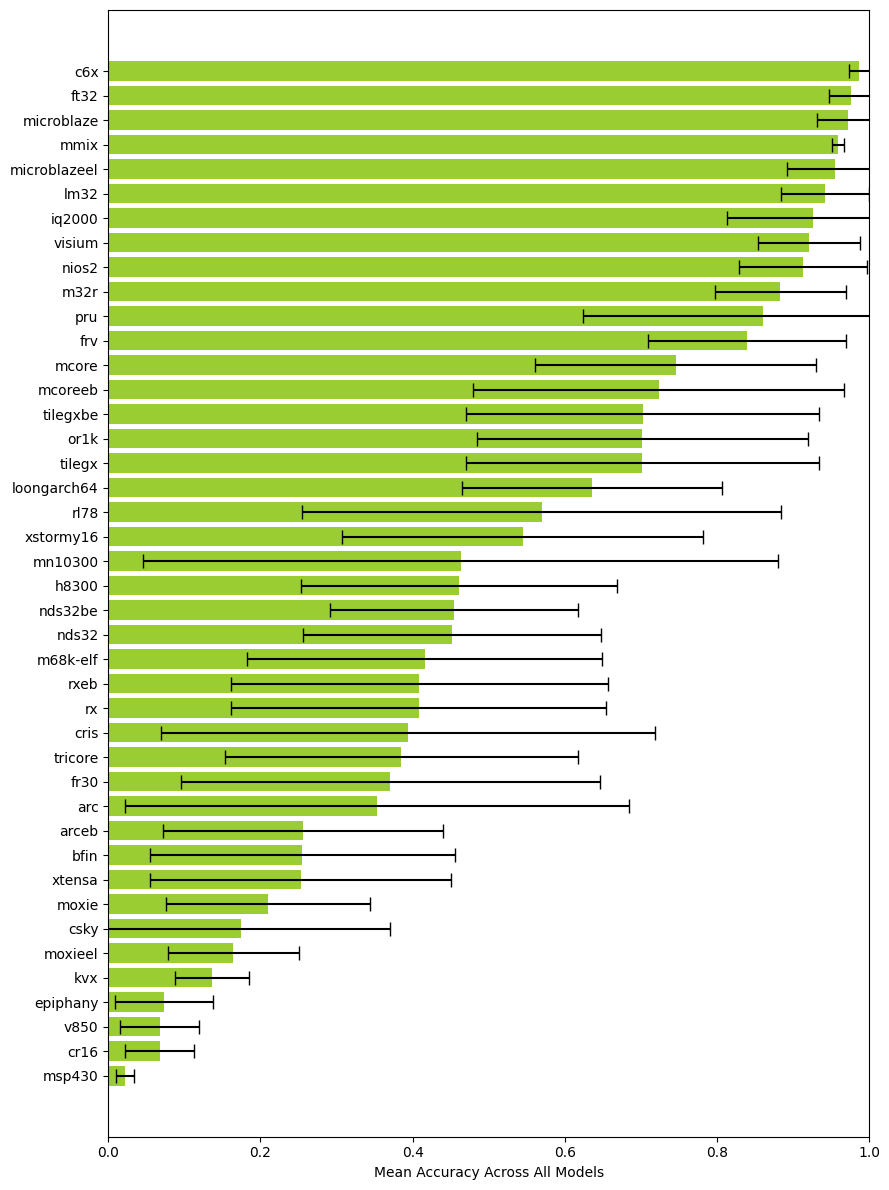

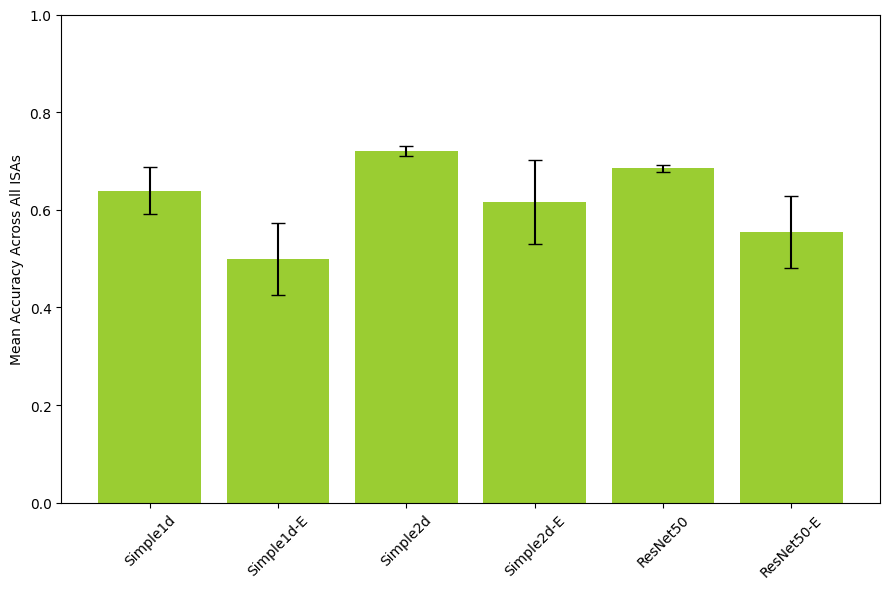

In [ ]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "BuildCross-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    model_results = {}
    arch_model_results = {}
    all_architectures = set()

    # Find all architecture columns
    arch_columns = [
        col
        for col in df_all.columns
        if col.startswith("test_accuracy_") and col != "test_accuracy"
    ]
    architectures = [col.replace("test_accuracy_", "") for col in arch_columns]
    all_architectures.update(architectures)

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        model_mean = df["test_accuracy"].mean()
        model_std = df["test_accuracy"].std()

        model_results[model_name] = (model_mean, model_std)

        # Collect per-architecture results
        for arch_col in arch_columns:
            arch = arch_col.replace("test_accuracy_", "")
            if arch not in arch_model_results:
                arch_model_results[arch] = {}

            arch_mean = df[arch_col].mean()
            arch_std = df[arch_col].std()
            arch_model_results[arch][model_name] = (arch_mean, arch_std)

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                values.append(arch_model_results[arch][model][0])
        if values:  # Only calculate if we have values
            arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (ascending)
    sorted_architectures = sorted(
        arch_means.keys(), key=lambda x: arch_means[x], reverse=False
    )

    # Create horizontal bar chart aggregated by architecture
    plt.figure(figsize=(9, 12))
    arch_means_list = []
    arch_stds_list = []

    for arch in sorted_architectures:
        arch_values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                arch_values.append(arch_model_results[arch][model][0])
        if arch_values:  # Only calculate if we have values
            arch_means_list.append(np.mean(arch_values))
            arch_stds_list.append(np.std(arch_values))

    bars = plt.barh(
        range(len(sorted_architectures)),
        arch_means_list,
        xerr=arch_stds_list,
        capsize=5,
        color="yellowgreen",
    )
    plt.yticks(range(len(sorted_architectures)), sorted_architectures)
    plt.xlabel("Mean Accuracy Across All Models")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig(
        f"output/buildcross-{target_feature.replace('_', '').lower()}-by-isa.png"
    )

    # Create bar chart aggregated by model
    plt.figure(figsize=(9, 6))
    model_means = []
    model_stds = []

    for model in model_names:
        mean, std = model_results[model]
        model_means.append(mean)
        model_stds.append(std)

    xticks = [model.replace("Embedding", "-E") for model in model_names]

    bars = plt.bar(
        range(len(model_names)),
        model_means,
        yerr=model_stds,
        capsize=5,
        color="yellowgreen",
    )
    plt.xticks(range(len(model_names)), xticks, rotation=45)
    plt.ylabel("Mean Accuracy Across All ISAs")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(
        f"output/buildcross-{target_feature.replace('_', '').lower()}-by-model.png"
    )

In [ ]:
# Create a combined results table per architecture
for target_feature in target_features:
    model_results = {}
    arch_model_results = {}
    all_architectures = set()

    # Find all architecture columns
    arch_columns = [
        col
        for col in df_all.columns
        if col.startswith("test_accuracy_") and col != "test_accuracy"
    ]
    architectures = [col.replace("test_accuracy_", "") for col in arch_columns]
    all_architectures.update(architectures)

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        model_mean = df["test_accuracy"].mean()
        model_std = df["test_accuracy"].std()
        model_results[model_name] = (model_mean, model_std)

        # Collect per-architecture results
        for arch_col in arch_columns:
            arch = arch_col.replace("test_accuracy_", "")
            if arch not in arch_model_results:
                arch_model_results[arch] = {}

            arch_mean = df[arch_col].mean()
            arch_std = df[arch_col].std()
            arch_model_results[arch][model_name] = (arch_mean, arch_std)

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                values.append(arch_model_results[arch][model][0])
        if values:  # Only calculate if we have values
            arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (ascending)
    sorted_architectures = sorted(
        arch_means.keys(), key=lambda x: arch_means[x], reverse=False
    )

    # Create the combined table
    table_string = "| Architecture |"
    for model in model_names:
        table_string += f" {model} |"
    table_string += "\n| ------------ |"
    table_string += " ------------: |" * len(model_names)
    table_string += "\n"

    # Add rows for each architecture
    for arch in sorted_architectures:
        table_string += f"| {arch} |"
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                mean, std = arch_model_results[arch][model]
                table_string += f" {mean:.3f}±{std:.3f} |"
            else:
                table_string += " - |"
        table_string += "\n"

    # Add overall row
    table_string += "| **Overall** |"
    for model in model_names:
        mean, std = model_results[model]
        table_string += f" **{mean:.3f}±{std:.3f}** |"
    table_string += "\n"

    # Save the table
    filename = f"output/buildcross-{target_feature.replace('_', '').lower()}-combined-results.md"
    with open(filename, "w") as f:
        f.write(table_string)

    print(f"Results table for {target_feature}:")
    print(table_string)

Results table for endianness:
| Architecture | Simple1d | Simple1dEmbedding | Simple2d | Simple2dEmbedding | ResNet50 | ResNet50Embedding |
| ------------ | ------------: | ------------: | ------------: | ------------: | ------------: | ------------: |
| rxeb | 0.022±0.008 | 0.096±0.054 | 0.065±0.020 | 0.075±0.069 | 0.068±0.018 | 0.051±0.045 |
| arceb | 0.033±0.017 | 0.097±0.030 | 0.064±0.010 | 0.052±0.018 | 0.248±0.019 | 0.094±0.075 |
| h8300 | 0.166±0.117 | 0.291±0.316 | 0.240±0.033 | 0.107±0.136 | 0.214±0.005 | 0.063±0.080 |
| fr30 | 0.320±0.181 | 0.090±0.155 | 0.225±0.112 | 0.016±0.016 | 0.433±0.077 | 0.143±0.278 |
| pru | 0.020±0.007 | 0.053±0.027 | 0.038±0.010 | 0.081±0.039 | 0.923±0.034 | 0.173±0.075 |
| xtensa | 0.059±0.007 | 0.391±0.130 | 0.175±0.036 | 0.191±0.094 | 0.583±0.053 | 0.208±0.066 |
| mcoreeb | 0.014±0.005 | 0.478±0.289 | 0.294±0.084 | 0.441±0.348 | 0.768±0.070 | 0.367±0.294 |
| nds32be | 0.175±0.093 | 0.395±0.083 | 0.597±0.139 | 0.235±0.053 | 0.761±0.100 | 0.295±0.